# A BICHO VISTO, CONTAMINACIÓN SEGURA

Este código explica el uso de una red neuronal NASNET pre entrenada para clasificar imágenes en una aplicación de identificación de microbiología acuática.
Se elabora únicamente a efectos didácticos y de demostración, pero es plenamente funcional. El usuario puede aportar sus propias imágenes para identificar.

wakervall.wordpress.com

In [1]:
### A BICHO VISTO, CONTAMINACION SEGURA

# Cargamos las librerias
import keras # Facilita el uso de redes neruonales con TensorFlow
import matplotlib.pyplot as plt # Librería para graficar datos
import numpy as np # Librería para calculo matricial

# Cargamos 2 funciones para edicion de imagenes
from PIL import Image, ImageOps # 

Using TensorFlow backend.


### Importacion de red NASNet preentrenada

La libería Keras incorpora redes neuronales predefinidas e incluso entreanadas, y permite transferencia de aprendizaje. Aunque la tendremos instalada en local, la red entrenada debe descargarse del repositorio github, pero se conecta automáticamente.

Cargamos el modelo NASNET Large que utiliza tamaños de imágenes de 331x331 píxeles para mejorar la diferenciación de los detalles en las imágenes. Esta red neuronal es demasiado grande para ser entrenada en una máquina doméstica (más de 88 millones de parámetros), así que no lo haremos, ni tampoco introduciremos modificaciones.

Para evitarlo, en la carga, tomamos la red entrenada, usando el aprendizaje realizado con el conjunto Imagenet (image-net.org). El modelo pesa bastante (más de 300 Mb) y tardará unos minutos en descargarse la primera vez que ejecutemos el código.

In [2]:
# Definimos el modelo a partir del existente en Keras
model = keras.applications.nasnet.NASNetLarge(input_shape=None, include_top=True, weights='imagenet',
    input_tensor=None, pooling=None, classes=1000)

# Classes=1000 utilizará 1000 categorias para la clasificacion, requiere haber indicado 
# include_top=True para mantener la red totalmente conectada a nivel superior y no hacer entrenamiento adicional

# En funcion de la versión de tensorflow (libreria de bajo nivel para redes neuronales que utiliza Keras),
# durante la definición del modelo pueden aparecer avisos WARNIN:tensorflow. No hay que preocuparse.


In [3]:
# Informacion sobre el modelo de red NASNet Large entrado que hemos cargado
model.summary()

# Nos informa del tipo y dimensiones de cada una de sus más de 1200 capas
# Y del número de parámetros de cada una, además del total.
# Vemos que la primera capa usa una matriz de dimensiones 331x331x3, que es la resolución de entrada de las imagenes en tres canales RGB
# Las capas intermedias van concentrando las características en las imagenes 
# La última es una capa de predicción tiene 1000 neuronas, cuyos pesos seran la probabilidad para cada una de las 1000 categorías de clasificacion

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 331, 331, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 165, 165, 96) 0           stem_bn1[0][0]                   
__________________________________________________________________________________________________
reduction_

cropping2d_4 (Cropping2D)       (None, 21, 21, 2016) 0           zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
reduction_concat_reduce_12 (Con (None, 11, 11, 2688) 0           reduction_add_2_reduce_12[0][0]  
                                                                 reduction_add3_reduce_12[0][0]   
                                                                 add_4[0][0]                      
                                                                 reduction_add4_reduce_12[0][0]   
__________________________________________________________________________________________________
adjust_avg_pool_1_13 (AveragePo (None, 11, 11, 2016) 0           adjust_relu_1_13[0][0]           
__________________________________________________________________________________________________
adjust_avg_pool_2_13 (AveragePo (None, 11, 11, 2016) 0           cropping2d_4[0][0]               
__________

### Uso del modelo para identificación de imágenes

Para usar el modelo simplemente tenemos que cargar una imagen desde la misma carpeta en la que se encuente este cuaderno de Jupyter, reescalarla a la resolución de entrada (331x331 píxeles) y convertirla en una matriz numérica con el formato adecuado. Después simplemente le pediremos que haga una predicción.

También podemos pedirle que nos informe del grado de confianza de esa predicción y de las mejores otras opciones que ha considerado, en términos procentuales.

El uso del modelo es muy rápido, ya que solo tiene que aplicar los pesos creados durante el aprendizaje, y no solo puede usarse en ordenadores personales, sino que podría cargarse en un dispositivo móvil o incluso en un microordenador tipo Raspberry Pi.

In [4]:
# Cargamos la imagen de un nemátodo
img = Image.open('nematodo_micro_optico.jpg')

# Reescalamos la imagen cargada a la resolucion de entrada que necesita la red NASNetLarge
img = ImageOps.fit(img, (331, 331), Image.ANTIALIAS)

# Convertimos la imagen re escalada en una matriz numérica multidimensional
img_array = np.asarray(img, dtype="int16")

# Vemos las dimensiones de la matriz
print('Forma de la matriz:', img_array.shape)

print('Dimensiones matriz:', img_array.ndim)

Forma de la matriz: (331, 331, 3)
Dimensiones matriz: 3


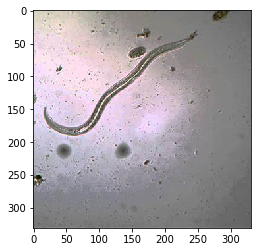

In [5]:
# Mostramos la matriz numerica que contiene la imagen cargada
plt.imshow(img_array )

In [6]:
# Keras esta preparado para trabajar con lotes de imagenes, el modelo NASNET está construido sobre Keras

# Añadimos una nueva dimensión a la matriz para indicarle el numero de la imagen que entrará al modelo dentro del lote
# De esta manera podemos usar esa dimension como indice de las imagenes y suministrar un lote de ellas

# Esto es necesario aunque solo usemos una sola imagen en prediccion, porque Keras permite manejar miles de ellas
img_array = img_array[np.newaxis,...]

print('Forma de la matriz reempaquetada:', img_array.shape)
print('Dimensiones matriz reempaquetada:', img_array.ndim)

Forma de la matriz reempaquetada: (1, 331, 331, 3)
Dimensiones matriz reempaquetada: 4


In [7]:
# Preprocesamos la matriz para adaptarla al formato especifico que requiere el modelo NASNET
# Unos modelos usan un rango de valores (0,1), otros (-1,1), etc. 
# El preprocesado es una utilidad de Keras que nos evita preocuparse por los detalles internos de un modelo predefinido
img_array = keras.applications.nasnet.preprocess_input(img_array)

In [9]:
# Ejecutamos el modelo para predecir la categoría de la imagen, poniendo el resultado en una variable
y = model.predict(img_array)

#  Mostramos la probabilidad de las 5 categorías con mayor valor con un pequeño bucle
# Keras tiene otra utilidad para decodificar las predicciones de los modelos precargados (decode)
for index, res in enumerate(keras.applications.nasnet.decode_predictions(y)[0]):
    # Formato de impresion "Nº . especie predicha : porcentaje redondeado a 3 decimales"
    print('{}. {}: {:.3f}%'.format(index+1, res[1], 100*res[2]))

1. nematode: 86.933%
2. thunder_snake: 0.128%
3. hook: 0.044%
4. isopod: 0.043%
5. flatworm: 0.042%


### Limitaciones del modelo

Cualquier modelo de clasificación, solo puede predecir las categorias de imagenes que conoce, es decir, alguna de las 1000 que estaban en el conjunto Imagenet utilizado. Así, NASNET Large puede reconocer un nemátodo, un coche o un avión. 

Pero en nuestro caso, como queremos aplicarlo a identificación de microbios en agua, el aspecto de la imagen puede variar considerablemente en función del grado de aumentos con que fué tomada, las técnicas de tinción, etc... Por ello, el modelo tendrá problemas por ejemplo con un rotífero, o confundirá bacterias con otras cosas. No es que funcione mal, simplemente, que no ha sido entrenado con las imágenes apropiadas. E incluso en estas condiciones puede utilizarse, sabiendo que cuando diga anémonas u hormigas, probablemente esté "viendo" bacterias.

Para mejorarlo se debe incrementar el conjunto de imágenes con nuevas categorías de microbiología, de manera que aprenda a detectarlas, o utilizar un conjunto específico solo para microbiología del agua, en cuyo caso se podría reducir el número de categorías y la complejidad d ela red neuronal. Pero en cualquier caso, a pesar de ser un modelo general, es fácil de usar y plenamente funcional, como queríamos demostrar.

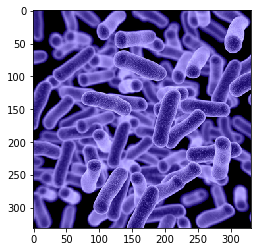

In [10]:
# Cargamos otra imagen, con la que tendrá problemas
img = Image.open('purple-germs.jpg')

# Escalamos la imagen a la resolucion de NASNetLarge
img = ImageOps.fit(img, (331, 331), Image.ANTIALIAS)

# Convertimos la imagen re escalada en una matriz numérica
img_array = np.asarray(img, dtype="int16")

# Representamos la matriz numerica
plt.imshow(img_array )

In [11]:
# Añadimos la nueva dimensión y preprocesamos la imagen para introducirla al modelo
img_array = img_array[np.newaxis,...]
img_array = keras.applications.nasnet.preprocess_input(img_array)

# Ejecutamos el modelo y mostramos las 5 categorías más probables
y = model.predict(img_array)

for index, res in enumerate(keras.applications.nasnet.decode_predictions(y)[0]):
    # Formato de impresion "Nº . especie predicha : porcentaje redondeado a 3 decimales"
    print('{}. {}: {:.3f}%'.format(index+1, res[1], 100*res[2]))

1. sea_anemone: 74.714%
2. anemone_fish: 16.502%
3. coral_reef: 0.356%
4. sea_urchin: 0.218%
5. brain_coral: 0.094%


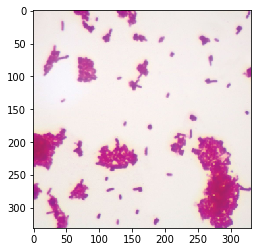

In [12]:
# Cargamos otra imagen más
img = Image.open('e_coli_micro_optico.jpg')

# Escalamos la imagen a la resolucion de NASNetLarge
img = ImageOps.fit(img, (331, 331), Image.ANTIALIAS)

# Convertimos la imagen re escalada en una matriz numerica
img_array = np.asarray(img, dtype="int16")

# La mostramos
plt.imshow(img_array )

In [13]:
# Añadimos la nueva dimensión y preprocesamos la imagen antes de meterla en el modelo
img_array = img_array[np.newaxis,...]
img_array = keras.applications.nasnet.preprocess_input(img_array)

# Ejecutamos el modelo y mostramos las 5 categorías más probables
y = model.predict(img_array)

for index, res in enumerate(keras.applications.nasnet.decode_predictions(y)[0]):
    # Formato de impresion "Nº . especie predicha : porcentaje redondeado a 3 decimales"
    print('{}. {}: {:.3f}%'.format(index+1, res[1], 100*res[2]))

1. ant: 26.593%
2. Petri_dish: 12.333%
3. nematode: 1.972%
4. face_powder: 1.720%
5. syringe: 1.601%


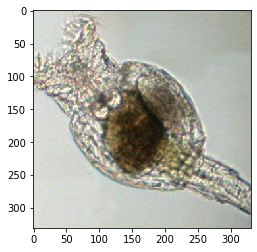

In [14]:
# Cargamos la última imagen
img = Image.open('rotifer_micro_optico.jpg')

# Escalamos a la resolucion de NASNetLarge
img = ImageOps.fit(img, (331, 331), Image.ANTIALIAS)

# Convertimos la imagen re escalada en una matriz numérica
img_array = np.asarray(img, dtype="int16")

# La mostramos
plt.imshow(img_array )

In [15]:
# Añadimos una nueva dimensión y preprocesamos la imagen antes de pasarla al modelo
img_array = img_array[np.newaxis,...]
img_array = keras.applications.nasnet.preprocess_input(img_array)

# Ejecutamos el modelo y mostramos las 5 categorías más probables
y = model.predict(img_array)

for index, res in enumerate(keras.applications.nasnet.decode_predictions(y)[0]):
    # Formato de impresion "Nº . especie predicha : porcentaje redondeado a 3 decimales"
    print('{}. {}: {:.3f}%'.format(index+1, res[1], 100*res[2]))

1. nematode: 88.910%
2. flatworm: 0.081%
3. isopod: 0.071%
4. damselfly: 0.051%
5. hook: 0.046%
